# Thermostats in Molecular Dynamics Simulations

A key component of MD simulations is the thermostat, which is used to control the temperature of the system. This document explains the theoretical background of two common thermostats, the Langevin and the Berendsen thermostats, and how to implement them in Sarkas.

## Langevin Thermostat

The Langevin thermostat controls the temperature by simulating the interaction of particles with a heat bath through frictional and random forces. The Langevin equation for a particle of mass $m$ and velocity $\vec{v}$ is given by:

$$
m \frac{d\vec{v}}{dt} = \vec{F} - \gamma m \vec{v} + \vec{R}
$$

where:
- $\vec{F}$ represents deterministic forces,
- $\gamma$ is the friction coefficient,
- $\vec{R}$ is often modeled as Gaussian white noise with a mean of zero and a variance determined by the fluctuation-dissipation theorem.

The fluctuation-dissipation theorem connects the random force's statistics to the temperature $T$ of the system and the friction coefficient $\gamma$, ensuring the system reaches thermal equilibrium. The properties of the $i$ th component of the vector $\vec{R}(t)$ are:

$$
\langle R_i(t) \rangle = 0, \quad \langle R_i(t) R_j(t') \rangle = 2 \gamma k_B T_d m \delta_{ij}\delta(t-t')
$$

where $k_B$​ is the Boltzmann constant, $\delta_{ij}$ is the Kronecker delta, and $\delta(t-t')$ is the Dirac delta function.

This approach not only adjusts the system's temperature but also accurately reproduces the correct physical dynamics under the influence of a heat bath, making it particularly suitable for systems where the solvent effects are significant.

Solving the Langevin equation, with the assumption of $F = 0$ for simplicity, we arrive at 

$$ \vec{v}(t) = \vec{v}(0)e^{-\gamma t} + \frac{1}{m} \int_0^{t}ds \, e^{-\gamma (t - s)} \vec{R}(s) $$

Calculating the temperature $T = m \langle v^2(t)\rangle$, with $k_B = 1$

$$
T(t) =  m \langle v^2(0)\rangle e^{-2\gamma t} + \frac{1}{m}\int_0^{t}ds \int_0^{t}ds' \, e^{-\gamma (2t - s - s')} \langle \vec{R}(s) \cdot \vec{R}(s') \rangle \\
= T(0)e^{-2\gamma t} + \frac{1}{m} e^{-2\gamma t} \int_0^{t}ds \int_0^{t}ds' \, e^{\gamma( s + s')} 2 \gamma k_BT_d m \delta(s - s') \\
=  T(0) e^{-2\gamma t}+ \frac{1}{m}e^{-2\gamma t}  2 \gamma T_d m  \int_0^{t}ds' e^{2 \gamma s'} \\
=  T(0) e^{-2\gamma t} + e^{-2\gamma t}  T_d   \left (e^{2 \gamma t}  - 1\right ).$$

We arrive at the temperature evolution equation

$$ T(t) =  T(0) e^{-2\gamma t} +  T_d\left (1 - e^{- 2 \gamma t} \right )$$



## Berendsen Thermostat

The Berendsen thermostat, unlike the Langevin approach, does not simulate individual particle interactions with a heat bath. Instead, it rescales the velocities of all particles in the system to bring the kinetic temperature towards a target value over a specified relaxation time.
In a strict velocity scaling approach the temperature $T$ is estimated, through a quantity proportional to $\langle v^2 \rangle$, and the velocities are scaled to values consistent with the desired temperature $T_d$, as in $v_i \mapsto \alpha v_i$. Being completely consistent with physical laws,
it is preferable to use the same simple algorithm but more gently so that the dynamics during the thermostat period is more consistent with the underlying equations of motion. 

In the BT we begin with a model for the temperature as we would like to see it evolve over a slower
timescale $\tau_{B}$. One model is

$$
   \frac{dT}{dt} = \frac{T_d - T}{\tau_{B}},
$$

This equation can be solved analytically to yield

$$
   T(t) = T(0)e^{-t/\tau_B} + \left(1 - e^{-t/\tau_B}  \right)T_d ,
$$

which can be seen to transition from the initial temperature $T(0)$ to the desired temperature $T_d$
on a time scale of $\tau_{B}$. 

### Berendsen algorithm

To implement BT we discretize the BT model across one time step to obtain

$$
   T(t + \Delta t) = T(t) + \frac{\Delta t}{\tau_B}\left(T_d - T(t) \right).
$$

We want to scale the current velocities such that this new temperature $T(t+\Delta t)$ is achieved,
because that the temperature prescribed by the BT.
Finding the ratio then of the target temperature and the current temperature, we get

$$
   \frac{T(t + \Delta t)}{T(t) } = 1 + \frac{\Delta t}{\tau_{B}}\left(\frac{T_d}{T(t) } - 1 \right).
$$

Taking the square root of this yields the scaling factor for the velocities:

$$
\alpha = \sqrt{ 1+ \frac{\Delta t}{\tau_{B}}\left(\frac{T_d}{T(t) } - 1 \right) }.
$$


## Choosing $\tau_B$ and $\gamma$

We can choose $\tau_{B},\gamma$ by deciding how close we want to be to the target temperature $T_d$. Say we choose we want to be within 1% of the target temperature. This means that we want the exponential term to be $e^{-t/\tau_B} = e^{-2\gamma t} = 0.01$. Inverting this equation we find

$$ -t/\tau_B = -2 \gamma t = \log(0.01) = -  4.6051 $$

Assuming that we want our thermostat to reach the 1% threshold within one plasma period ($\tau_p = 2 \pi / \omega_p$), we find 

$$ \tau_B = \frac{\tau_p}{4.6}, \quad \gamma = \frac{2.3}{\tau_p}.$$

In Sarkas the parameter `berendsen_tau` is equivalent to $\tau_B/\Delta t$ while `langevin_gamma` is equivalent to $\gamma$. Note that $\tau_B$ has units of time therefore we will have to divide by the timestep $\Delta t$ to find the value to pass to `berendsen_tau`.

The code below calculates `berendsen_tau` and `langevin_gamma` with the above assumptions.

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
plt.style.use('MSUstyle')
# Import sarkas
from sarkas.processes import PreProcess

# Create the file path to the YAML input file
input_file_name = os.path.join('input_files', 'yocp_quickstart.yaml' )

pre = PreProcess(input_file_name)
pre.setup(read_yaml=True)

tau_p = 2.0 * np.pi /pre.parameters.total_plasma_frequency

tau_B = - tau_p/np.log(0.01)/pre.parameters.dt
gamma_L = - np.log(0.01)/(2.0 * tau_p)

print(f'\n\nNumber of timesteps per plasma period = {tau_p/pre.parameters.dt:.2f} [timesteps]')
print(f'Berendsen tau = {tau_B:.2f}')
print(f'Langevin gamma = {gamma_L:.4e} [Hertz]')





Number of timesteps per plasma cycle = 496.38 [timesteps]
Berendsen tau = 107.79
Langevin gamma = 9.2774e+13 [Hertz]


The above output means that in order for the temperature to be within 1% of the desired temperature within one plasma period, we have to choose  `berendsen_tau: 108` or `langevin_gamma: 9.277e+13`. 

In the following we select six different values of `berendsen_tau` and `langevin_gamma` and for each of them run a simulation. The simulation has an equilibration phase `eq_steps` long and a production phase of 5 plasma periods. The variable `cycles` is the number (or ratio) of plasma periods within which the temperature should decay to 1% of its initial value. 

In [2]:
cycles = np.array([0.01, 0.1, 0.2, 1.0, 5.0, 10.0])

eq_steps = np.rint( 2.0 * cycles * tau_p/ pre.parameters.dt).astype(int)

langevins = - np.log(0.01)/(2.0 * tau_p) /cycles
taus = - tau_p / np.log(0.01) * cycles/ pre.parameters.dt

print('Berendsen taus =', taus)
print('Langevin gammas =', langevins)
print('Equilibration steps =', eq_steps)

Berendsen taus = [   1.07788312   10.77883119   21.55766238  107.7883119   538.94155949
 1077.88311897]
Langevin gammas = [9.27744375e+15 9.27744375e+14 4.63872187e+14 9.27744375e+13
 1.85548875e+13 9.27744375e+12]
Equilibration steps = [  10   99  199  993 4964 9928]


The script (`berendsen_script.py`)[berendsen_script.py] is used to run six simulation with a Berendsen thermostat and six simulations with a Langeving thermostat. The following code is instead is used top analyze the results.

The code reads the output of the simulations and makes plots of the temperature vs time for the two different thermostat and their parameters.

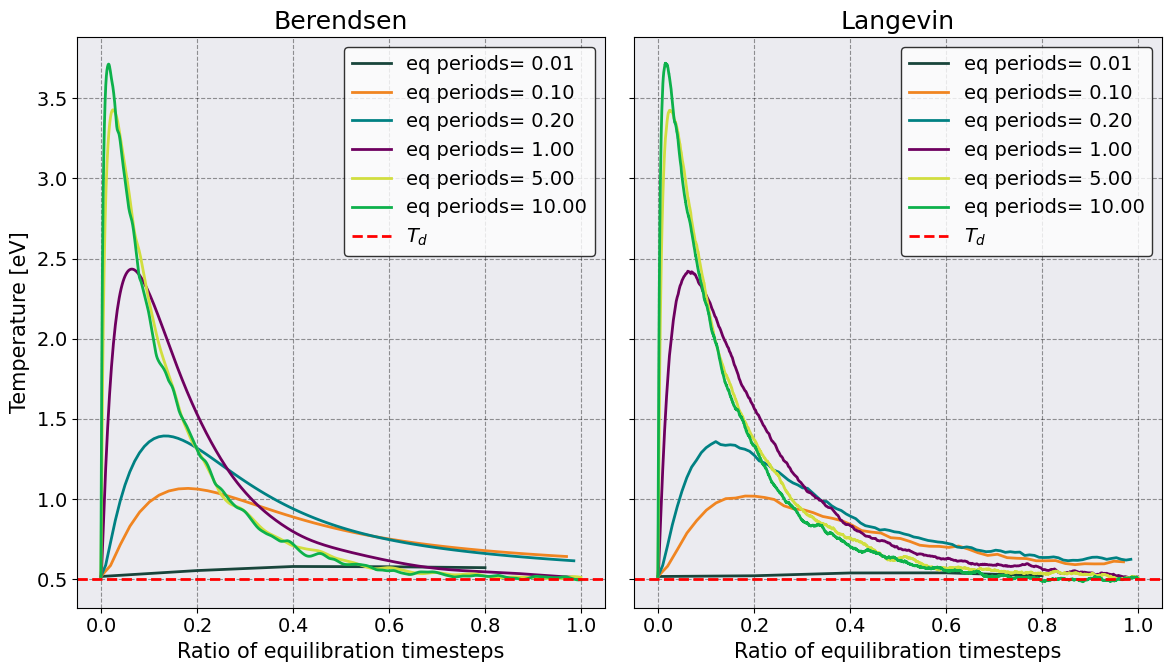

In [21]:
from sarkas.processes import PostProcess
from sarkas.tools.observables import Thermodynamics

fig, axt = plt.subplots(1,2, sharey = True, sharex = True, figsize = (12, 7))
for j, ipf in enumerate(["yocp_quickstart.yaml", 'yocp_quickstart_langevin.yaml']):
    # Create the file path to the YAML input file
    input_file_name = os.path.join('input_files', ipf)

    for i, cycle in enumerate(cycles):

        if j == 0:
            args = {
                'Integrator': {'thermalization_timestep': 0, # Timesteps before turning on the thermostat
                            'berendsen_tau': taus[i]}, # Change tau for each simulation
                "Parameters":{ "rand_seed": 123456,
                                "equilibration_steps": eq_steps[i]},
                "IO":   # Store all simulations' data in simulations_dir,
                        # but save the dumps in different subfolders (job_dir)
                    {
                        "job_dir": f"tau_cycles{cycles[i]:.2f}",
                        "verbose": False # This is so not to print to screen for every run
                    },
            }
        else:
                
            args = {
                'Integrator': {'langevin_gamma': langevins[i]}, # Change tau for each simulation
                "Parameters":{ "rand_seed": 123456,
                            "equilibration_steps": eq_steps[i]},
                "IO":   # Store all simulations' data in simulations_dir,
                        # but save the dumps in different subfolders (job_dir)
                    {
                        "job_dir": f"gamma_cycles{cycles[i]:.2f}",
                        "verbose": False # This is so not to print to screen for every run
                    },
            }

        # Get the simulation's parameters
        postproc = PostProcess(input_file_name)
        postproc.setup(read_yaml=True, other_inputs = args)
        # Initialize the Thermodynamics class
        therm = Thermodynamics()
        # Set the attributes of the class from the parameters of the simulation
        therm.setup(postproc.parameters, phase = 'equilibration')
        # Compute the thermodynamics. There is nothing to compute here, the only thing done is read the data dumped during the simulation
        therm.compute()
        # Rescaling the time. dt is used to get the number of steps and eq_steps is the number of equilibration steps.
        # In this way the x-axis should have a max of 1
        time_rescaling = therm.dt * (eq_steps[i])
        # Call sarkas method to plot the data. 
        therm.plot(
            scaling = (time_rescaling, therm.eV2K),   # Rescaling the time and temperature.
            y = ('Temperature', 'Mean'),            # Select the column in therm.dataframe to plot.
            ylabel = 'Temperature [eV]',            # Label for the y-axis.
            xlabel = 'Ratio of equilibration timesteps', # Label for the x-axis.
            ax = axt[j]                             # Select the subplot to plot the data.
            )

    axt[j].axhline(postproc.parameters.species_temperatures_eV[0], ls = '--', color = 'r')
    # Set the legend
    lgnd = [r'eq periods' + f'= {c:.2f}' for _, c in enumerate(cycles)]
    lgnd.append(r'$T_d$')
    axt[j].legend(lgnd)

axt[0].set_title('Berendsen')
axt[1].set_title('Langevin')
fig.tight_layout()


Notice that the x-axis is not the total time or the number of timesteps, rather is the ratio of equilibration timesteps. This means that the simulation time has been rescaled such that all the curves would end at the same spot. What we would have expected is that each curve would end at the 1% of $T_d = 0.5$ [eV]. However, that is not what we see. We see an initial heating for all cases and the maximum temperature depends on the strength of the thermostat (_i.e._ the larger eq periods the weaker the thermostat). The stronger the thermostat the smaller the maximum temperature. The heating is called disorder induced heating (DIH) and is due to the initial configurational energy of the system. Placing the particles randomly in space creates an initial potential energy landscape that is not the equilibrium one and as such once the particles are left to evolve the will try and find their equilibrium. 



Text(0.5, 1.0, 'Langevin')

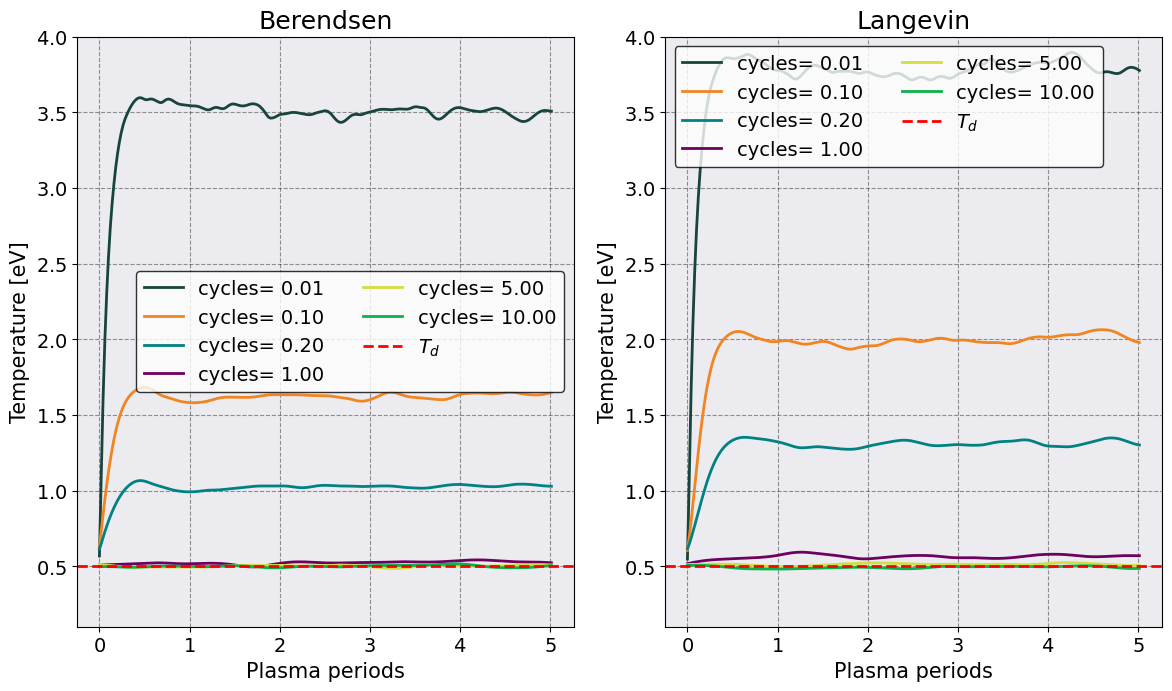

In [15]:
fig, axt = plt.subplots(1,2, figsize = (12, 7))
for j, ipf in enumerate(["yocp_quickstart.yaml", 'yocp_quickstart_langevin.yaml']):
    # Create the file path to the YAML input file
    input_file_name = os.path.join('input_files', ipf)

    for i, cycle in enumerate(cycles):

        if j == 0:
            args = {
                'Integrator': {'thermalization_timestep': 0, # Timesteps before turning on the thermostat
                            'berendsen_tau': taus[i]}, # Change tau for each simulation
                "Parameters":{ "rand_seed": 123456,
                                "equilibration_steps": eq_steps[i]},
                "IO":   # Store all simulations' data in simulations_dir,
                        # but save the dumps in different subfolders (job_dir)
                    {
                        "job_dir": f"tau_cycles{cycles[i]:.2f}",
                        "verbose": False # This is so not to print to screen for every run
                    },
            }
        else:
                
            args = {
                'Integrator': {'langevin_gamma': langevins[i]}, # Change tau for each simulation
                "Parameters":{ "rand_seed": 123456,
                            "equilibration_steps": eq_steps[i]},
                "IO":   # Store all simulations' data in simulations_dir,
                        # but save the dumps in different subfolders (job_dir)
                    {
                        "job_dir": f"gamma_cycles{cycles[i]:.2f}",
                        "verbose": False # This is so not to print to screen for every run
                    },
            }

        postproc = PostProcess(input_file_name)
        postproc.setup(read_yaml=True, other_inputs = args)
        therm = Thermodynamics()
        therm.setup(postproc.parameters, phase = 'production')
        therm.compute()
        time_rescaling = therm.plasma_period 
        therm.plot(
            scaling = (time_rescaling, therm.eV2K),   
            y = ('Temperature', 'Mean'), 
            ylabel = 'Temperature [eV]',
            xlabel = 'Plasma periods', ax = axt[j])

    axt[j].axhline(postproc.parameters.species_temperatures_eV[0], ls = '--', color = 'r')
    # axt.axvline(608, ls = '--', color = 'r')
    lgnd = [r'cycles' + f'= {c:.2f}' for _, c in enumerate(cycles)]
    lgnd.append(r'$T_d$')
    axt[j].legend(lgnd, ncol = 2)
    axt[j].set_ylim(0.1, 4.0)
axt[0].set_title('Berendsen')
axt[1].set_title('Langevin')